# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Введение в анализ данных" </center>

# <center> Лабораторная работа №2. Кластерный анализ. </center>

# Часть 1

В данном задании вам необходимо **самостоятельно** реализовать один из алгоритмов кластеризации.  
По аналогии с классами в scikit-learn, нужно реализовать класс, наследуемый от [Base Estimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html).  
Подробнее про реализацию своих моделей в scikit-learn: [here](https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator).  
В классе помимо `__init__()` нужно реализовать два метода:
 - `fit()` - метод, выполняющий кластеризацию данных.
 - `predict()` - метод, определяющий для нового объекта, к какому из кластеров он относится. 
 
Для удобства можно создавать дополнительные методы класса, которые будут вызываться в `fit()` или `predict()`.  <br>
Функции для вычисления расстояний *между объектами* самим реализовывать не нужно, используйте реализации из `scipy`.

In [10]:
import sys
import warnings
import time
import random
import numpy as np
import pandas as pd
from scipy.spatial.distance import sqeuclidean
from sklearn.base import BaseEstimator, ClusterMixin

warnings.filterwarnings('ignore')

class IslamKMeans:
    def __init__(self, k=5, init='k-means++', n_init=10,
                 max_iter=300, tol=0.0001):
        """
        Initialization of K-Means algorithm
        :param k: number of clusters
        :param init: method for initialization k-means++ or random
        :param n_init: number of time the k-means algorithm will be run
                       with different centroid seeds
        :param max_iter: Maximum number of iterations of
                         the k-means algorithm for a single run
        :param tol: relative tolerance
        """
        self.k = k
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol

        self.X = ''
        self.inertia_ = float(sys.maxsize)
        self.cluster_centers_ = list()
        self.labels_ = ''
        self.clusters = [[] for _ in range(self.k)]
        self.n_samples = int
        self.n_features = int

    def k_means_plus(self):
        """
        Selects initial cluster centers for
        k-mean clustering in a smart way to speed up convergence
        :return: None
        """
        centroids_buf = list()
        random_sample_id = np.random.choice(self.n_samples, 1,
                                            replace=False)
        centroids_buf.append(self.X[random_sample_id])
        for id in range(self.k - 1):
            dist = []
            for i in range(self.n_samples):
                point = self.X[i, :]
                d = sys.maxsize
                for j in range(len(centroids_buf)):
                    temp_dist = sqeuclidean(point, centroids_buf[j])
                    d = min(d, temp_dist)
                dist.append(d)
            dist = np.array(dist)
            next_centroid = self.X[np.argmax(dist), :]
            centroids_buf.append(next_centroid)
        self.cluster_centers_ = list(centroids_buf)

    def random_find(self):
        """
        Choose n_clusters observations (rows) at random
        from data for the initial centroids
        :return: None
        """
        random_sample_idxs = np.random.choice(self.n_samples,
                                              self.k,
                                              replace=False)
        self.cluster_centers_ = [self.X[idx] for idx in random_sample_idxs]

    def fit(self, data):
        """
        Compute k-means clustering.
        :param data: algorithm training data
        :return: None
        """
        best_labels = self.labels_
        best_inertia = float(sys.maxsize)
        best_centroids = self.cluster_centers_
        self.X = data
        self.n_samples, self.n_features = data.shape
        for _ in range(self.n_init):
            if self.init == 'k-means++':
                self.k_means_plus()
            else:
                self.random_find()
            for _ in range(self.max_iter):
                self.clusters = self.add_to_cluster(self.cluster_centers_)
                self.cluster_centers_ = self.get_centres(self.clusters)
                if self.check_inertia() is True:
                    break
            if self.inertia_ < best_inertia:
                self.get_labels(clusters=self.clusters)
                best_labels = self.labels_.copy()
                best_centroids = self.cluster_centers_.copy()
                best_inertia = self.inertia_
        self.labels_ = best_labels.copy()
        self.cluster_centers_ = best_centroids.copy()
        self.inertia_ = best_inertia

    def predict(self, data):
        """
        Predict the closest cluster each sample in X belongs to.
        :param data: algorithm prediction data
        :return: list of the labels
        """
        self.X = data
        self.n_samples, self.n_features = data.shape
        other_clusters = self.create_clusters(self.cluster_centers_)
        return self.get_labels(other_clusters)

    def get_labels(self, clusters):
        """
        Turns the list of clusters into an easy-to-process list
        :param clusters: list of clusters
        :return: None
        """
        self.labels_ = np.empty(self.n_samples, dtype=int)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                self.labels_[sample_index] = cluster_idx

    def add_to_cluster(self, centroids):
        """
        Creates and adds points to specific clusters
        :param centroids: list of centroids
        :return: list of clusters
        """
        clusters = list()
        for _ in range(self.k):
            clusters.append([])
        for idx, sample in enumerate(self.X):
            centroid_idx = self.nearest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    @staticmethod
    def nearest_centroid(element, centroids):
        """
        Find the nearest centroid
        :param element: a definite point in our data
        :param centroids: list of centroids
        :return: numpy array with the nearest centroid
        """
        distances = list()
        for val in centroids:
            cur_dist = sqeuclidean(element, val)
            distances.append(cur_dist)
        index = np.argmin(distances)
        return index

    def get_centres(self, clusters):
        """
        Initialize centres for clusters
        :param clusters: list of clusters
        :return: array of centroids
        """
        centroids = np.zeros((self.k, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def check_inertia(self):
        """
        Finds inertia and determines when 
        the algorithm needs to end the action
        :return: bool
        """
        distance = 0
        for i in range(len(self.clusters)):
            for j in range(len(self.clusters[i])):
                point = self.X[self.clusters[i][j]]
                distance += sqeuclidean(point, self.cluster_centers_[i])
        if abs(distance - self.inertia_) < self.tol:
            return True
        else:
            self.inertia_ = distance
            return False

### Вариант №3

Алгоритм K-Means.  
  
Параметры: 
- **k:** число центров (кластеров);
- **init**: метод инициализации центров - random или kmeans++;
- **n_init**: число запусков алгоритма;
- **max_iter:** максимальное число итераций;  
- **tol:** минимальное значение изменения целевой функции.  
  
Атрибуты:  
- **inertia_:** Итоговое значение целевой функции;
- **cluster\_centers\_:** центры кластеров - ndarray of shape (n_clusters, n_features);
- **labels_:** метки кластеров для каждого объекта.  
  
Метод `predict()`:  Новый объект определяется в кластер, центр которого расположен ближе всех к этому объекту. 

### Тестирование 

Вашу реализацию необходимо сравнить с питоновской реализацией алгоритма из `sklearn` или `scipy`. Результаты кластеризации должны совпадать.  
Также необходимо сравнить скорость работы вашей реализации и питоновской (это нормально, если ваша реализация будет медленнее).  
Сравнение необходимо выполнить на наборе данных iris.

In [11]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
iris = load_iris()
X_train = iris.data # использовать для кластеризации
y = iris.target # истинные метки цветков
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [14]:
X = pd.DataFrame(X_train, columns=iris.feature_names)
X['class'] = [iris.target_names[i] for i in y]
X

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

         class  
0       setosa  
1       setosa  
2       setosa  
3       setosa  
4       setosa  
..         ...  
145  virginica  
146  virginica  
147  virginica  
148  virginica  
149  virginica  

[150 rows x 5 columns]

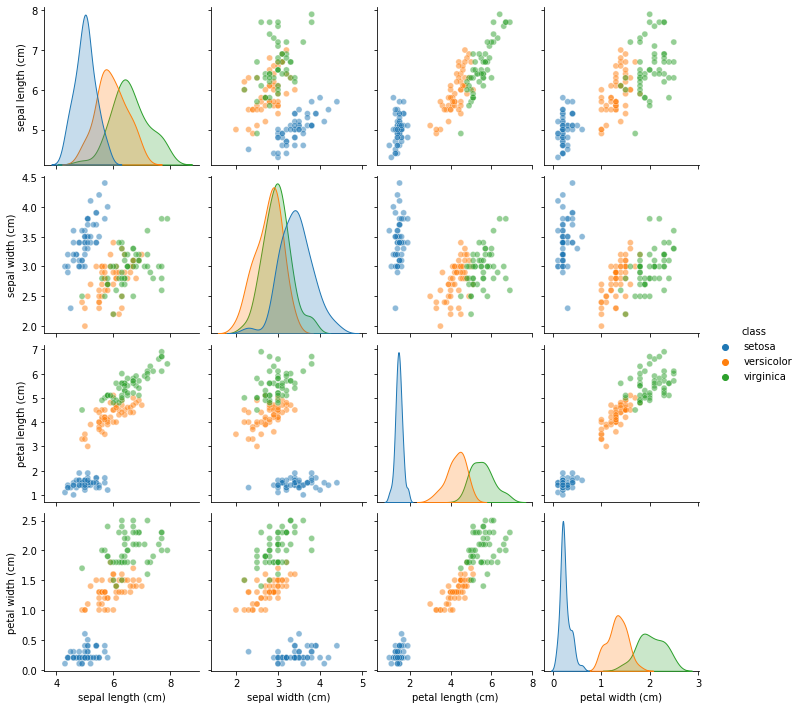

In [15]:
sns.pairplot(X, hue='class', plot_kws={'alpha':0.5}, vars=iris.feature_names)
plt.show()

#### В первую очередь нам для тестирования алгоритмов необходимо провести стандартизацию данных. Для этого используем StandardScaler

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
sc = StandardScaler()
scal_data = sc.fit_transform(X_train)

In [18]:
scal_X = pd.DataFrame()
for point, i in zip(iris.feature_names, range(len(iris.feature_names))):
    scal_X[point] = scal_data[:, i]

#### Тестирование IslamK-Means

In [39]:
islam_k_means = IslamKMeans(k=3)
scal_data_copy = scal_X.copy()

In [40]:
st_time = time.time()
islam_k_means.fit(scal_data_copy.to_numpy())
fin_time = time.time()
islam_k_means_time = fin_time - st_time

#### Визуализация полученных результатов

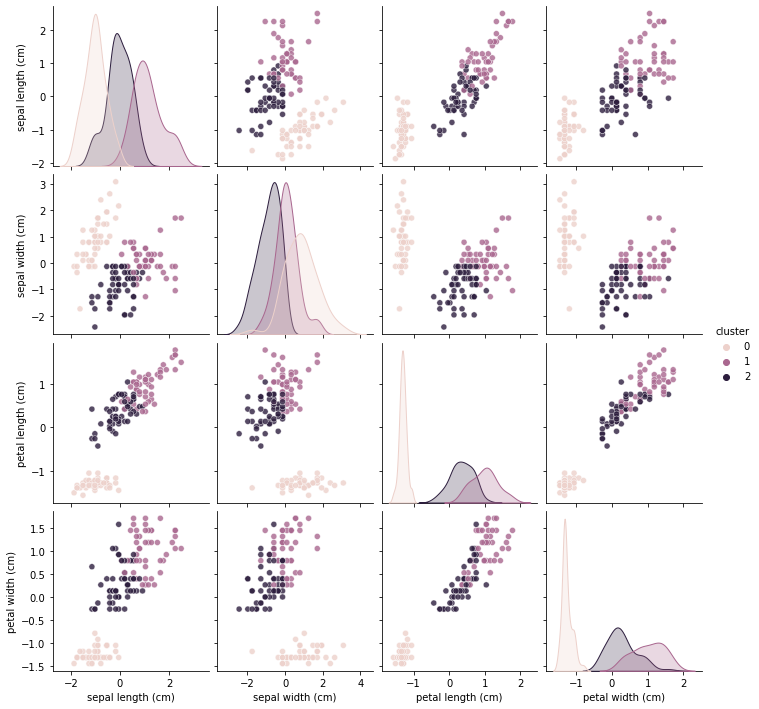

In [41]:
scal_data_copy['cluster'] = islam_k_means.labels_
sns.pairplot(scal_data_copy, hue='cluster', 
             plot_kws={'alpha': 0.8}, vars=iris.feature_names,
             )
plt.show()

#### Запуск Scikit learn K-Means

In [45]:
from sklearn.cluster import KMeans
order_kmeans = KMeans(n_clusters=3, init='k-means++')
st_time = time.time()
order_kmeans.fit(scal_X)
fin_time = time.time()
order_kmeans_time = fin_time - st_time

#### Cделаем сравнение Scikit learn K-Means и IslamKMeans

In [46]:
print("Распределение кластеров K-Means:")
print(order_kmeans.labels_)
print("Распределение кластеров IslamKMeans:")
print(islam_k_means.labels_)
print("---------------------")
print("Инерция K-Means: ", order_kmeans.inertia_)
print("Инерция IslamK-Means: ", islam_k_means.inertia_)
print("---------------------")
print("Время работы K-Means: ", order_kmeans_time)
print("Время работы IslamK-Means: ", islam_k_means_time)

Распределение кластеров K-Means:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2
 2 1 1 1 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 2 1 2 1 1
 2 1 2 2 1 1 1 1 2 1 2 1 2 1 1 2 2 1 1 1 1 1 2 2 1 1 1 2 1 1 1 2 1 1 1 2 1
 1 2]
Распределение кластеров IslamKMeans:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2
 2 1 1 1 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 2 1 1 1 1
 1 1 2 2 1 1 1 1 2 1 2 1 2 1 1 2 1 1 1 1 1 1 2 2 1 1 1 2 1 1 1 2 1 1 1 2 1
 1 2]
---------------------
Инерция K-Means:  140.03275277428654
Инерция IslamK-Means:  139.82049635974974
---------------------
Время работы K-Means:  0.042366743087768555
Время работы IslamK-Means:  0.638108491897583


### Вывод
Как мы видим результаты обеих кластеризаций полностью идентичны. Конечно, ожидалось, что обычный K-Means работает намного быстрее, чем моя реализация. Также стоит отметить, что при различных запусках время может отличатся, я считаю, это зависим от рандома, так как в k-means он также имеется, это происходит при определении первой точки

### Бонусное  
  
Дополнительно вы можете поработать над эффективностью алгоритма по скорости и памяти, добавить поддержку многопоточности, или расширить базовый функционал.

#### Вариант №3

In [10]:
Vars[Vars.iloc[:,2] == 3]

ФИО Группа  Вариант №
4             Боряев Сергей Сергеевич  1 ИАД          3
6         Дыряев Даниил Александрович  1 ИАД          3
8         Игумнова Наталья Дмитриевна  1 ИАД          3
13          Мурзинов Михаил Денисович  1 ИАД          3
14           Николаева Олеся Игоревна  1 ИАД          3
16            Османов Ислам Рамилевич  1 ИАД          3
19         Смирнов Григорий Андреевич  1 ИАД          3
20        Стифеев Никита Владимирович  1 ИАД          3
26      Арбузова Екатерина Михайловна  2 ИАД          3
31       Варгин Дмитрий Александрович  2 ИАД          3
37               Левин Глеб Сергеевич  2 ИАД          3
41         Смирнов Дмитрий Викторович  2 ИАД          3
44      Терентьева Анастасия Олеговна  2 ИАД          3
46            Точкова Арина Андреевна  2 ИАД          3
49           Шарапов Максим Сергеевич  2 ИАД          3
52           Юдакова Олеся Валерьевна  2 ИАД          3
54          Басыров Андрей Дмитриевич  3 ИАД          3
57  Закареишвили Гиоргий Годердзиевич  3 ИАД          3
62           Семенова Елена Андреевна  3 ИАД          3
65         Чернов Роман Александрович  3 ИАД          3
66       Шауклис Александр Николаевич  3 ИАД          3

# Часть 2

В данном задании вам предлагается проанализировать набор данных по различным городам США. Каждый город характеризуется следующими признаками:

In [48]:
pd.set_option('display.max_colwidth', None)

In [49]:
data_desc = pd.read_csv('Data_Description.txt', sep=':')
data_desc

Attribute  \
0                       Place   
1           Climate & Terrain   
2                     Housing   
3   Health Care & Environment   
4                       Crime   
5              Transportation   
6                   Education   
7                    The Arts   
8                  Recreation   
9                   Economics   
10                  Longitude   
11                   Latitude   
12                 Population   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Description  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                          City, state (postal code)  
1                                                                                                                                                                                                                                                                                                                              Very hot and very cold months, seasonal temperature variation, heating- and cooling-degree days, freezing days, zero-degree days, ninety-degree days.  
2                                                                                                                                                                                                                                                                                                                                                                                                                                  Utility bills, property taxes, mortgage payments.  
3                                                                                                                                                                                                                                                Per capita physicians, teaching hospitals, medical schools, cardiac rehabilitation centers, comprehensive cancer treatment centers, hospices, insurance/hospitalization costs index, flouridation of drinking water, air pollution.  
4                                                                                                                                                                                                                                                                                                                                                                                                                                           Violent crime rate, property crime rate.  
5                                                                                                                                                                                                                                                                                                                                                                                    Daily commute, public transportation, Interstate highways, air service, passenger rail service.  
6                                                                                                                                                                                                                                                                   

### Notes:   
* Для всех признаков, кроме трех, чем выше значение - тем лучше. Для признаков `Housing` и `Crime` - наоборот.
* Признак `Population`- статистический признак, не имеющий интерпретации как “лучше-хуже”.
* Признак `Place` - уникальный идентификатор объекта (города), он не должен использоваться при кластеризации.
* Также в данных присутствуют географические координаты городов - `Longitude` и `Latitude`. Их также не следует использовать при кластеризации данных.

In [50]:
data = pd.read_csv('Data.txt', sep=' ')
data

Place  Climate  HousingCost  HlthCare  Crime  \
0                    Abilene,TX      521         6200       237    923   
1                      Akron,OH      575         8138      1656    886   
2                     Albany,GA      468         7339       618    970   
3    Albany-Schenectady-Troy,NY      476         7908      1431    610   
4                Albuquerque,NM      659         8393      1853   1483   
..                          ...      ...          ...       ...    ...   
324                Worcester,MA      562         8715      1805    680   
325                   Yakima,WA      535         6440       317   1106   
326                     York,PA      540         8371       713    440   
327        Youngstown-Warren,OH      570         7021      1097    938   
328                Yuba-City,CA      608         7875       212   1179   

     Transp  Educ  Arts  Recreat  Econ      Long      Lat     Pop  
0      4031  2757   996     1405  7633  -99.6890  32.5590  110932  
1      4883  2438  5564     2632  4350  -81.5180  41.0850  660328  
2      2531  2560   237      859  5250  -84.1580  31.5750  112402  
3      6883  3399  4655     1617  5864  -73.7983  42.7327  835880  
4      6558  3026  4496     2612  5727 -106.6500  35.0830  419700  
..      ...   ...   ...      ...   ...       ...      ...     ...  
324    3643  3299  1784      910  5040  -71.7950  42.2720  402918  
325    3731  2491   996     2140  4986 -120.5130  46.5950  172508  
326    2267  2903  1022      842  4946  -76.7280  39.9600  381255  
327    3374  2920  2797     1327  3894  -80.7290  41.1700  531350  
328    2768  2387   122      918  4694 -121.6220  39.1280  101979  

[329 rows x 13 columns]

<br>  
  
## Задания: 

1. Выполните необходимую предобработку данных. Перед кластеризацией исключите из данных признаки `Place`, `Long` и `Lat`.  
  
  
2. Выполните кластеризацию иерархическим методом.  
Рассмотрите различные расстояния между объектами. Определите, какие следует использовать при кластеризации.  
Выполните кластеризацию с различными расстояниями между кластерами. Сравните результаты, сделайте выводы. 
  
  
3. Выполните кластеризацию методом Dbscan. Используйте расстояния между объектами, определенные в предыдущем пункте.  
Реализуйте эвристику (см. лекции) для выбора параметров алгоритма. Подберите подходящие параметры алгоритма.  
  
  
4. Выполните кластеризацию методом kmeans. Определите наилучшее (на ваш взгляд) число кластеров.  
  
  
5. (Бонусное) Выполните кластеризацию другими методами. Например, [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) или алгоритмы, [реализованные](https://scikit-learn.org/stable/modules/clustering.html) в scikit-learn.  
  
  
6. В результате выполнения предыдущих пунктов вы должны получить 4 или больше разбиений объектов (по одному на каждый метод). Сравните их между собой, сделайте выводы о сходствах и различиях.  
Оцените результаты каждой кластеризации, используя метрики, рассмотренные на занятиях (Silhouette и прочие).  
  
  
7. Выберите одно разбиение, наиболее подходящее на ваш взгляд. Предложите интерпретацию полученным кластерам или покажите, что этого сделать нельзя.  
  
  
8. Оцените, как полученные кластеры распределены географически.  
Оцените, как полученные кластеры распределены по штатам. Можно ли выделить какую-то зависимость (территориальную или для штатов)?  
(Бонусное) [Провизуализируйте](https://python-visualization.github.io/folium/quickstart.html) распределение на карте США.

# Задание 1
## Выполним препроцессинг данных

In [53]:
print(data.isnull().sum())
print("---------")
print(data.dtypes)

Place          0
Climate        0
HousingCost    0
HlthCare       0
Crime          0
Transp         0
Educ           0
Arts           0
Recreat        0
Econ           0
Long           0
Lat            0
Pop            0
dtype: int64
---------
Place           object
Climate          int64
HousingCost      int64
HlthCare         int64
Crime            int64
Transp           int64
Educ             int64
Arts             int64
Recreat          int64
Econ             int64
Long           float64
Lat            float64
Pop              int64
dtype: object


In [54]:
drop_coord_data = ['Lat', 'Long', 'Place']
data = data.drop(drop_coord_data, axis=1)

### Выполним стандартизацию данных

In [58]:
sc = StandardScaler()
scal_data = sc.fit_transform(data)
df = pd.DataFrame(data=scal_data, columns=data.columns)
df

Climate  HousingCost  HlthCare     Crime    Transp      Educ      Arts  \
0   -0.147006    -0.901297 -0.947340 -0.106712 -0.123592 -0.180726 -0.464893   
1    0.300664    -0.087570  0.469568 -0.210467  0.464411 -1.176652  0.520604   
2   -0.586386    -0.423054 -0.566902  0.025084 -1.158809 -0.795765 -0.628640   
3   -0.520064    -0.184142  0.244900 -0.984419  1.844699  1.823613  0.324497   
4    0.997040     0.019500  0.666278  1.463626  1.620402  0.659098  0.290194   
..        ...          ...       ...       ...       ...       ...       ...   
324  0.192892     0.154701  0.618348 -0.788127 -0.391369  1.511411 -0.294891   
325 -0.030943    -0.800525 -0.867458  0.406452 -0.330636 -1.011185 -0.464893   
326  0.010508     0.010262 -0.472042 -1.461129 -1.341007  0.275089 -0.459284   
327  0.259213    -0.556575 -0.088608 -0.064649 -0.577017  0.328164 -0.076347   
328  0.574240    -0.197998 -0.972303  0.611157 -0.995245 -1.335875 -0.653450   

      Recreat      Econ       Pop  
0   -0.546646  1.946433 -0.460990  
1    0.974442 -1.085467  0.154950  
2   -1.223512 -0.254304 -0.459342  
3   -0.283834  0.312735  0.351765  
4    0.949648  0.186213 -0.114824  
..        ...       ...       ...  
324 -1.160288 -0.448242 -0.133638  
325  0.364519 -0.498112 -0.391956  
326 -1.244586 -0.535052 -0.157925  
327 -0.643341 -1.506590  0.010350  
328 -1.150371 -0.767778 -0.471027  

[329 rows x 10 columns]

# Задание 2
## Иерархическая кластеризация

In [64]:
from scipy.cluster import hierarchy

## Method: Median || Metric: Euclidean

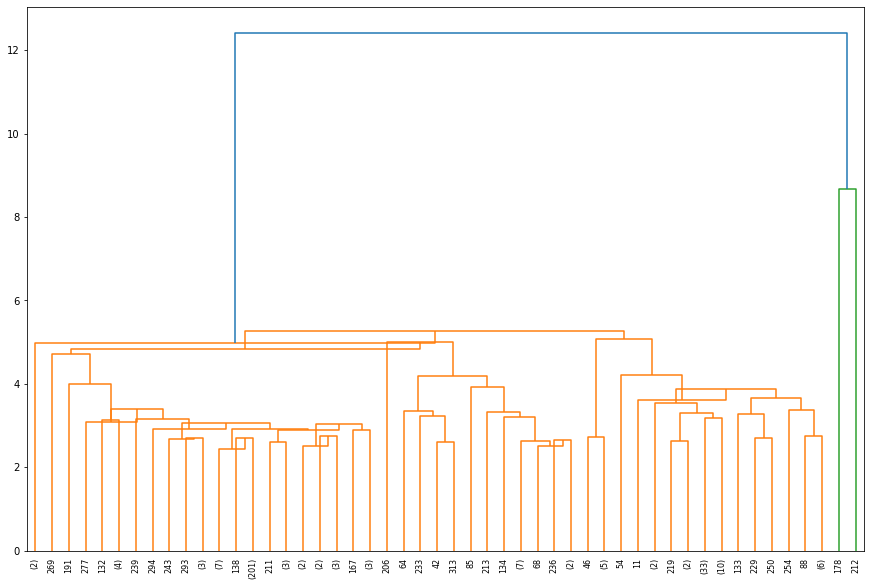

In [82]:
med_data = df.copy()
median_euclide_hier_clustering = hierarchy.linkage(med_data, 
                                                   method='median',
                                                   metric='euclidean'
                                                   )
median_euclide_labels = h.fcluster(median_euclide_hier_clustering,
                                   t=4,
                                   criterion='maxclust'
                                   )
plt.figure(figsize=(15,10))
hierarchy.dendrogram(median_euclide_hier_clustering, 
                     p=50, 
                     truncate_mode='lastp'
                     )
plt.show()

## Method: Weighted || Metric: CityBlock

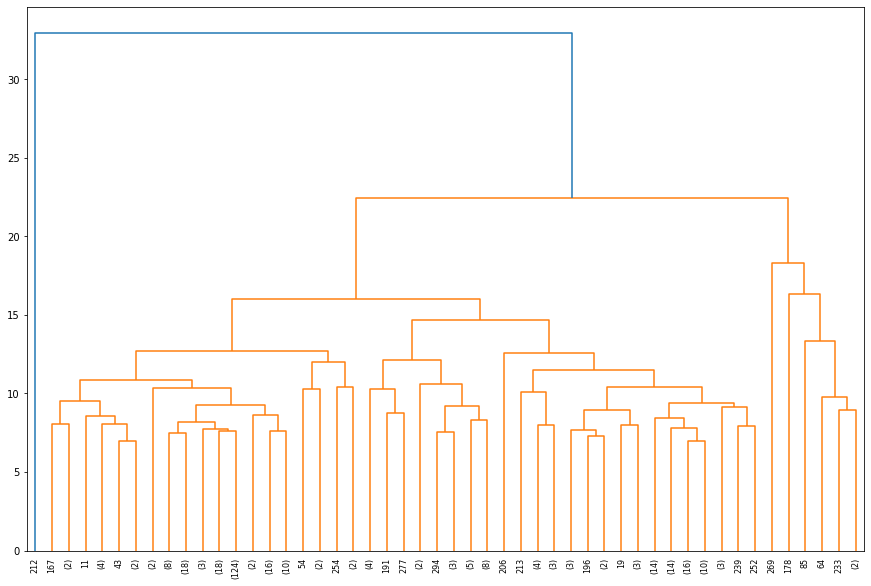

In [83]:
weight_data = df.copy()
weighted_city_block_hier_clustering = hierarchy.linkage(weight_data, 
                                                   method='weighted',
                                                   metric='cityblock'
                                                   )
weighted_city_block_labels = h.fcluster(weighted_city_block_hier_clustering,
                                   t=3,
                                   criterion='maxclust'
                                   )
plt.figure(figsize=(15,10))
hierarchy.dendrogram(weighted_city_block_hier_clustering, 
                     p=50, 
                     truncate_mode='lastp'
                     )
plt.show()

## Method: Weighted || Metric: Euclidean

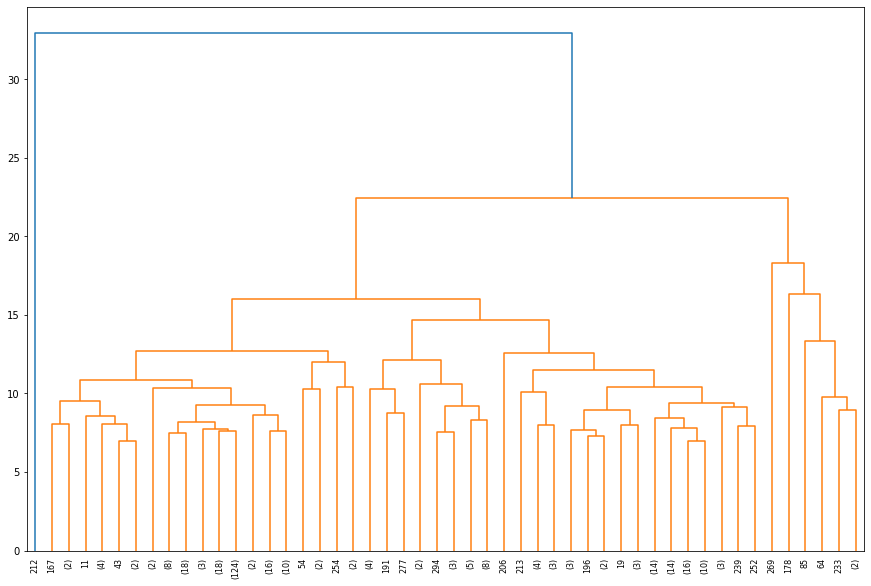

In [84]:
weight_data = df.copy()
weighted_eucl_hier_clustering = hierarchy.linkage(weight_data, 
                                                        method='weighted',
                                                        metric='euclidean'
                                                       )
weighted_eucl_labels = h.fcluster(weighted_eucl_hier_clustering,
                                  t=2,
                                  criterion='maxclust'
                                  )
plt.figure(figsize=(15,10))
hierarchy.dendrogram(weighted_city_block_hier_clustering, 
                     p=50, 
                     truncate_mode='lastp'
                     )
plt.show()

## Method: Complete || Metric: Euclidean

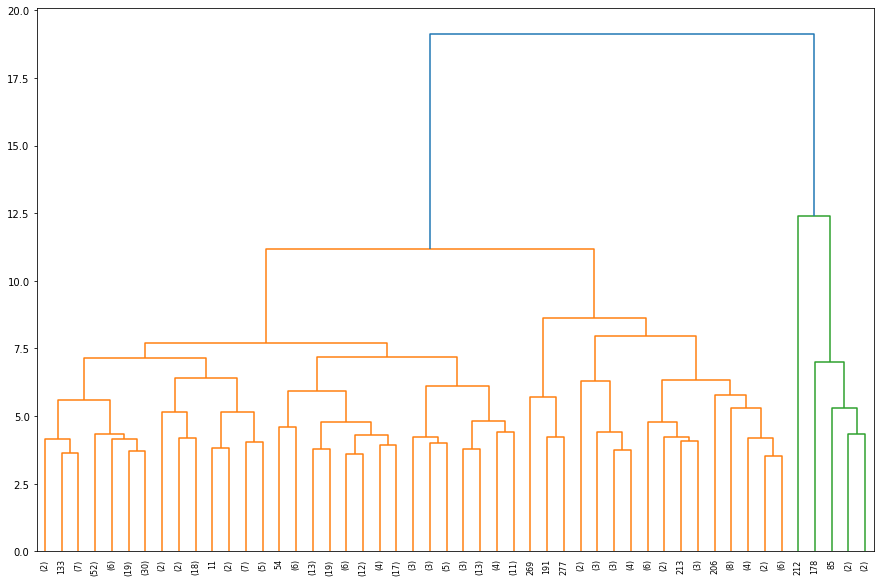

In [85]:
complete_data = df.copy()
complete_eucl_hier_clustering = hierarchy.linkage(complete_data, 
                                                   method='complete',
                                                   metric='euclidean'
                                                   )
complete_eucl_labels = h.fcluster(complete_eucl_hier_clustering,
                                   t=4,
                                   criterion='maxclust'
                                   )
plt.figure(figsize=(15,10))
hierarchy.dendrogram(complete_eucl_hier_clustering, 
                     p=50, 
                     truncate_mode='lastp'
                     )
plt.show()

## Method: Complete || Metric: Cos

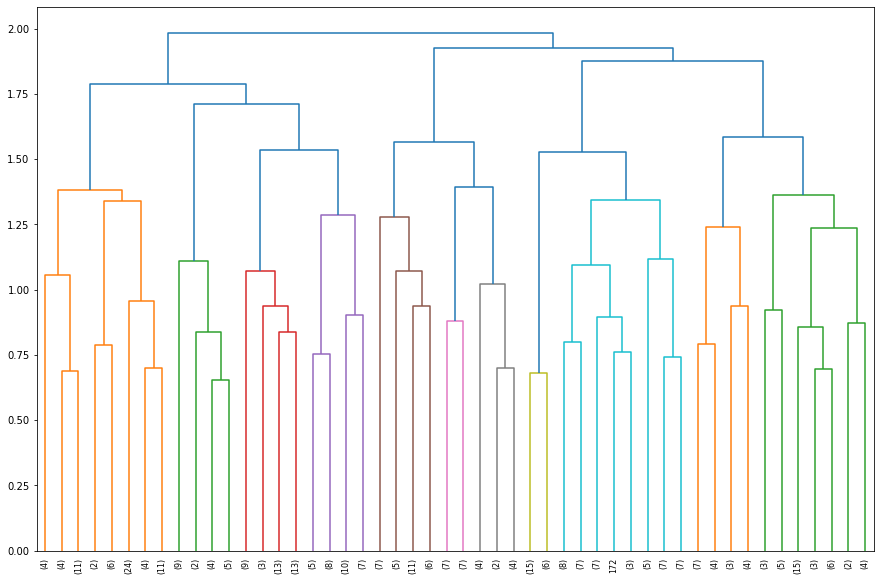

In [86]:
complete_data = df.copy()
complete_cos_hier_clustering = hierarchy.linkage(complete_data, 
                                                   method='complete',
                                                   metric='cos'
                                                   )
complete_cps_labels = h.fcluster(complete_cos_hier_clustering,
                                   t=4,
                                   criterion='maxclust'
                                   )
plt.figure(figsize=(15,10))
hierarchy.dendrogram(complete_cos_hier_clustering, 
                     p=50, 
                     truncate_mode='lastp'
                     )
plt.show()

## Method: Complete || Metric: CityBlock

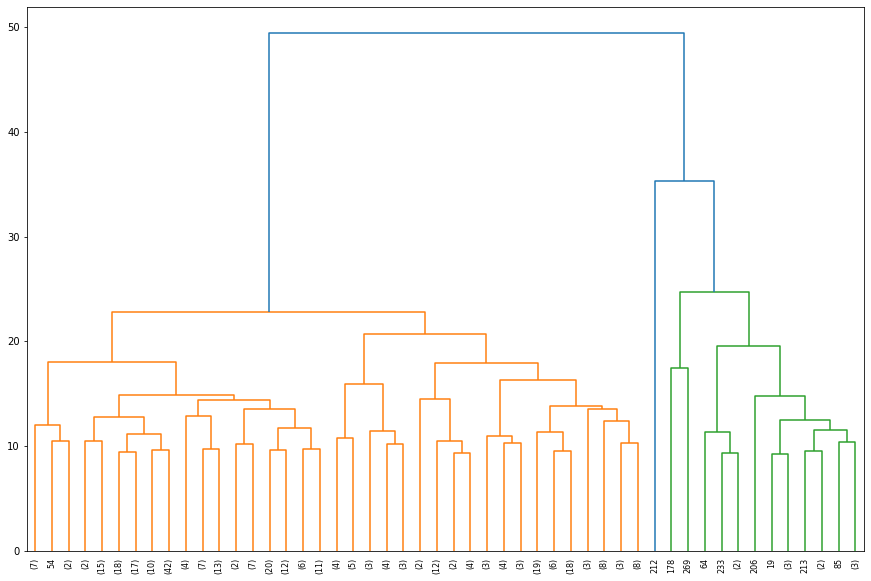

In [87]:
complete_data = df.copy()
complete_city_block_hier_clustering = hierarchy.linkage(complete_data, 
                                                   method='complete',
                                                   metric='cityblock'
                                                   )
complete_city_block_labels = h.fcluster(complete_city_block_hier_clustering,
                                   t=3,
                                   criterion='maxclust'
                                   )
plt.figure(figsize=(15,10))
hierarchy.dendrogram(complete_city_block_hier_clustering, 
                     p=50, 
                     truncate_mode='lastp'
                     )
plt.show()

## Method: Ward || Metric: Euclidean

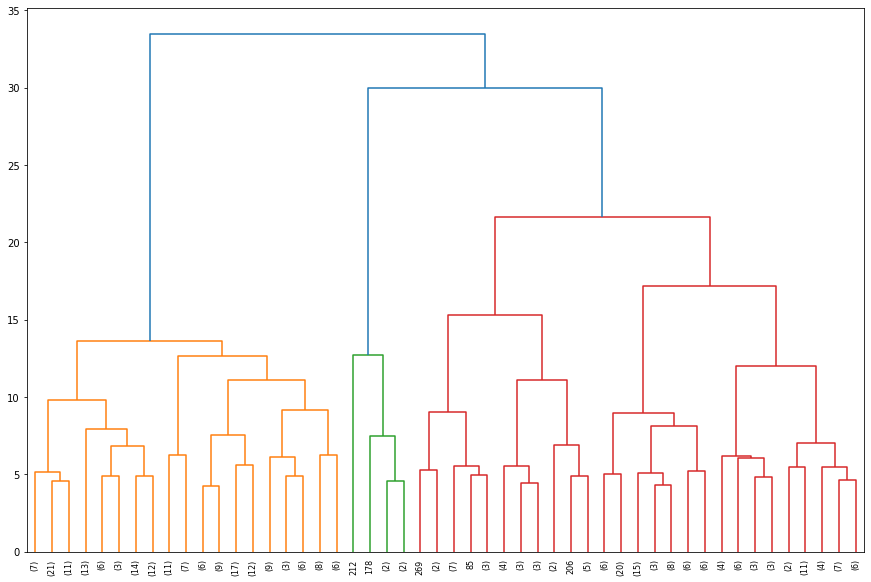

In [88]:
ward_data = df.copy()
ward_eucl_hier_clustering = hierarchy.linkage(complete_data, 
                                                   method='ward',
                                                   metric='euclidean'
                                                   )
ward_eucl_block_labels = h.fcluster(ward_eucl_hier_clustering,
                                        t=4,
                                        criterion='maxclust'
                                   )
plt.figure(figsize=(15,10))
hierarchy.dendrogram(ward_eucl_hier_clustering, 
                     p=50, 
                     truncate_mode='lastp'
                     )
plt.show()

## Оценим и сравним результаты работ алгоритма с различными гиперпараметрами

In [89]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

### Оценка по метрике silhouette_score

In [90]:
print("Method: Median || Metric: Euclidean: ", silhouette_score(df, median_euclide_labels))
print("Method: Weighted || Metric: CityBlock: ", silhouette_score(df, weighted_city_block_labels))
print("Method: Weighted || Metric: Euclidean: ", silhouette_score(df, weighted_eucl_labels))
print("Method: Complete || Metric: Euclidean: ", silhouette_score(df, complete_eucl_labels))
print("Method: Complete || Metric: CityBlock: ", silhouette_score(df, complete_city_block_labels))
print("Method: Ward || Metric: Euclidean: ", silhouette_score(df, ward_eucl_block_labels))

Method: Median || Metric: Euclidean:  0.6478850899934998
Method: Weighted || Metric: CityBlock:  0.5562037143963141
Method: Weighted || Metric: Euclidean:  0.7210215669560808
Method: Complete || Metric: Euclidean:  0.30531438121450893
Method: Complete || Metric: CityBlock:  0.44423939343496566
Method: Ward || Metric: Euclidean:  0.1480606777313674


### Оценка по метрике davies_bouldin_score

In [91]:
print("Method: Median || Metric: Euclidean: ", davies_bouldin_score(df, median_euclide_labels))
print("Method: Weighted || Metric: CityBlock: ", davies_bouldin_score(df, weighted_city_block_labels))
print("Method: Weighted || Metric: Euclidean: ", davies_bouldin_score(df, weighted_eucl_labels))
print("Method: Complete || Metric: Euclidean: ", davies_bouldin_score(df, complete_eucl_labels))
print("Method: Complete || Metric: CityBlock: ", davies_bouldin_score(df, complete_city_block_labels))
print("Method: Ward || Metric: Euclidean: ", davies_bouldin_score(df, ward_eucl_block_labels))

Method: Median || Metric: Euclidean:  0.21302475825256753
Method: Weighted || Metric: CityBlock:  0.6370658771596919
Method: Weighted || Metric: Euclidean:  0.5086651047848055
Method: Complete || Metric: Euclidean:  1.158058993470283
Method: Complete || Metric: CityBlock:  0.7999977049585052
Method: Ward || Metric: Euclidean:  1.8468990909824892


### Вывод
1) Данные плохо кластеризуются с помощью иерархической кластеризации, так многие попытки кластеризаций с различными метриками имеют плохохую оценку или плохое распределение.

2) Очень плохой результат выдал метод: median и метрика: euclidean, так как объекты - один большой кластер и оценки не такие хорошие

3) Нормальный результат показал метод: ward и метрика: euclidean, так имеется хорошее распределение в кластеров, они визуально заметны. Также неплохие оценки метрики

4) Также можно сказать о complete-cityblock и complete-euclidean. У одного кластера очень много элементов, даже можно сказать большинство. Хотя в complete-cityblock разделение получше, распределение более равномерное.

## Задание 3

### DBSCAN

In [93]:
from sklearn.cluster import DBSCAN
dbscan_df = df.copy()

### Euclidean

In [100]:
for min_sample in [2, 3, 4, 5]:
    for eps in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]:
        dbs = DBSCAN(eps=eps, min_samples=min_sample, metric='euclidean').fit(dbscan_df)
        print("eps = " + str(eps) + " min_samples = " + str(min_sample))
        print("The number of clusters: ", (np.max(dbs.labels_) + 1))
        print("The number of outliers: ", list(dbs.labels_).count(-1))
        print("-----------------------------")

eps = 0.5 min_samples = 2
The number of clusters:  0
The number of outliers:  329
-----------------------------
eps = 1.0 min_samples = 2
The number of clusters:  25
The number of outliers:  253
-----------------------------
eps = 1.5 min_samples = 2
The number of clusters:  8
The number of outliers:  104
-----------------------------
eps = 2.0 min_samples = 2
The number of clusters:  9
The number of outliers:  42
-----------------------------
eps = 2.5 min_samples = 2
The number of clusters:  4
The number of outliers:  18
-----------------------------
eps = 3.0 min_samples = 2
The number of clusters:  2
The number of outliers:  8
-----------------------------
eps = 3.5 min_samples = 2
The number of clusters:  2
The number of outliers:  4
-----------------------------
eps = 4.0 min_samples = 2
The number of clusters:  1
The number of outliers:  3
-----------------------------
eps = 0.5 min_samples = 3
The number of clusters:  0
The number of outliers:  329
-----------------------------

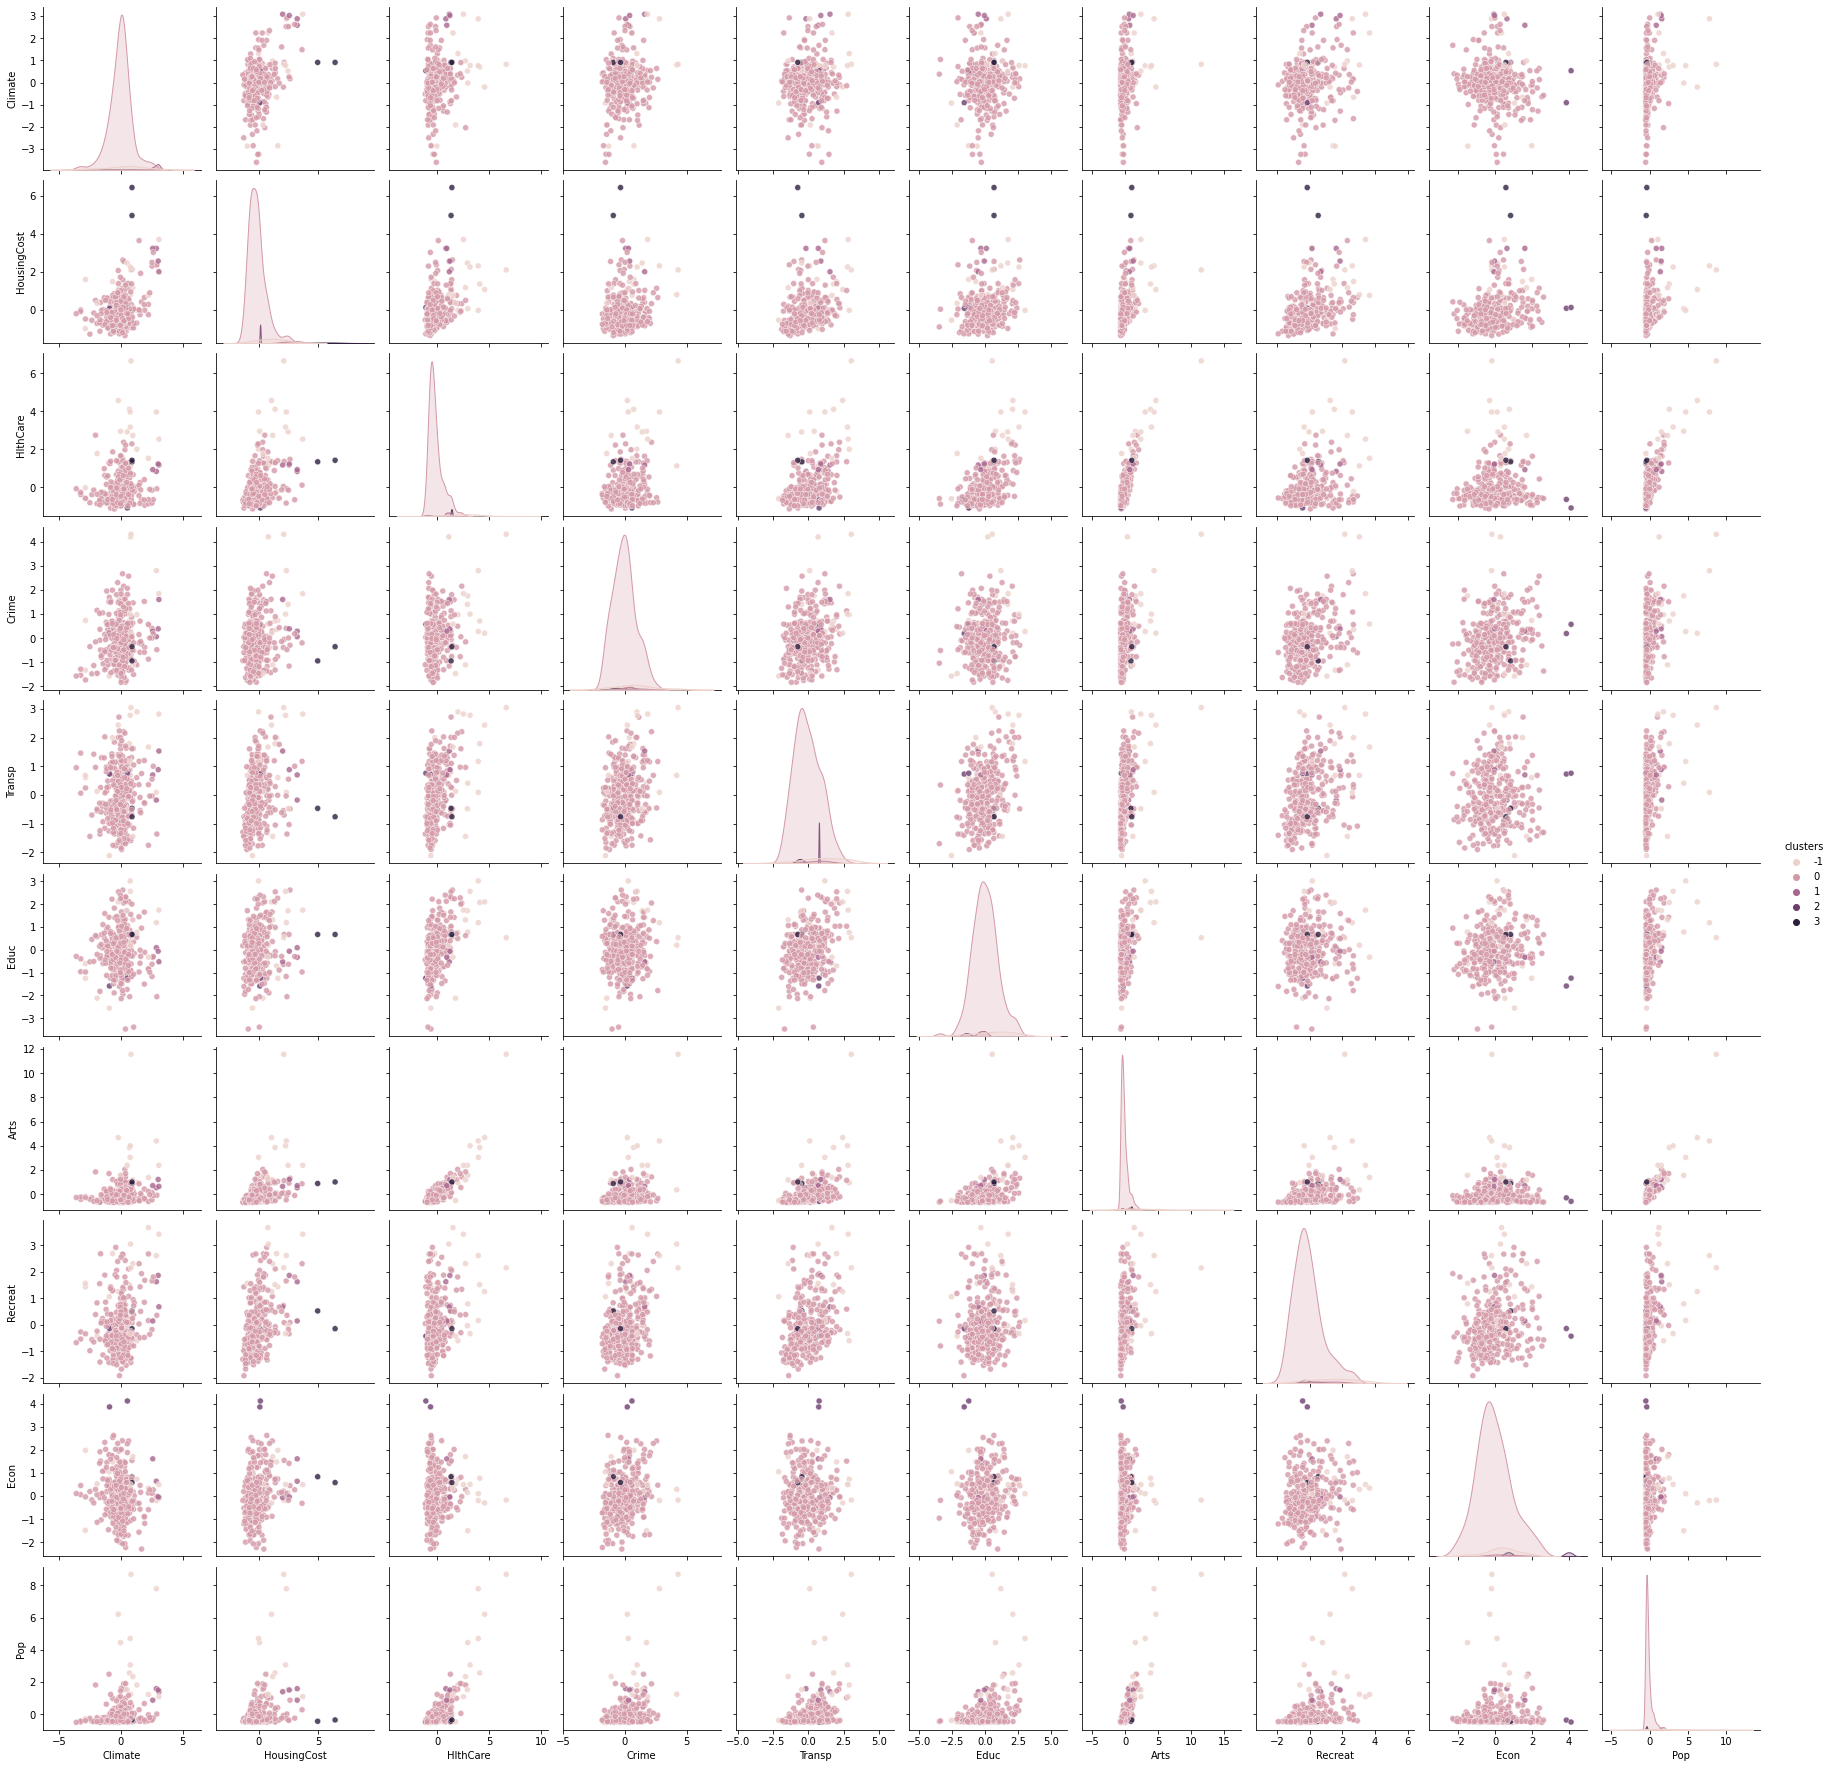

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0 -1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1
  0  0  2  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0 -1 -1  0  0
  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0
  0  0  0  0  1 -1  1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [103]:
dbs_min_eps = DBSCAN(eps=2.5, min_samples=2).fit(dbscan_df)
dbscan_df['clusters'] = dbs_min_eps.labels_
sns.pairplot(dbscan_df, hue='clusters', plot_kws={'alpha': 0.8})
plt.show()
print(dbs_min_eps.labels_)

### CityBlock

In [101]:
for min_sample in [2, 3, 4, 5]:
    for eps in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]:
        dbs = DBSCAN(eps=eps, min_samples=min_sample, metric='cityblock').fit(dbscan_df)
        print("eps = " + str(eps) + " min_samples = " + str(min_sample))
        print("The number of clusters: ", (np.max(dbs.labels_) + 1))
        print("The number of outliers: ", list(dbs.labels_).count(-1))
        print("-----------------------------")

eps = 0.5 min_samples = 2
The number of clusters:  0
The number of outliers:  329
-----------------------------
eps = 1.0 min_samples = 2
The number of clusters:  0
The number of outliers:  329
-----------------------------
eps = 1.5 min_samples = 2
The number of clusters:  0
The number of outliers:  329
-----------------------------
eps = 2.0 min_samples = 2
The number of clusters:  15
The number of outliers:  296
-----------------------------
eps = 2.5 min_samples = 2
The number of clusters:  26
The number of outliers:  236
-----------------------------
eps = 3.0 min_samples = 2
The number of clusters:  15
The number of outliers:  158
-----------------------------
eps = 3.5 min_samples = 2
The number of clusters:  7
The number of outliers:  119
-----------------------------
eps = 4.0 min_samples = 2
The number of clusters:  8
The number of outliers:  71
-----------------------------
eps = 0.5 min_samples = 3
The number of clusters:  0
The number of outliers:  329
--------------------

## Вывод
1) На самом деле DBSCAN не пдоходит для кластеризации данных таких форм. Ему необходимы определенные геотметр формы. Очень сложно найти формму для наших данных.

2) metric= cityblock в среднем показал очень плохие результаты. Так как это метрика многие точки просто помещает в outliers. Конечно, повышение epsilon и уменьшение min_samples дает определенные результаты, но они не столь ощутимы

3) Как по мне, наиболее хорошим вариантом является metric = euclidean eps=2.5, min_samples=2. Однако все же, хотя выбросов стало и меньше, но многие данные были помещены в один кластер, что не есть хорошо

# Задание 4

In [105]:
from sklearn.cluster import KMeans
kmeans_df = df.copy()

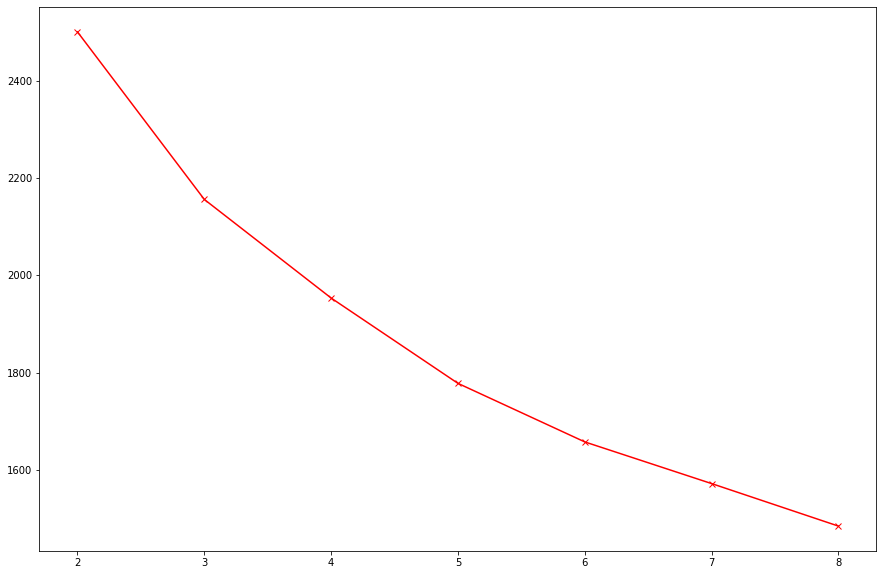

In [106]:
iner = []
for cluster in [2, 3, 4, 5, 6, 7, 8]:
    kmeans_opt_cluster = KMeans(n_clusters=cluster).fit(kmeans_df)
    iner.append(kmeans_opt_cluster.inertia_)
plt.figure(figsize=(15, 10))
plt.plot(range(2, 9), iner, 'x-r')
plt.show()

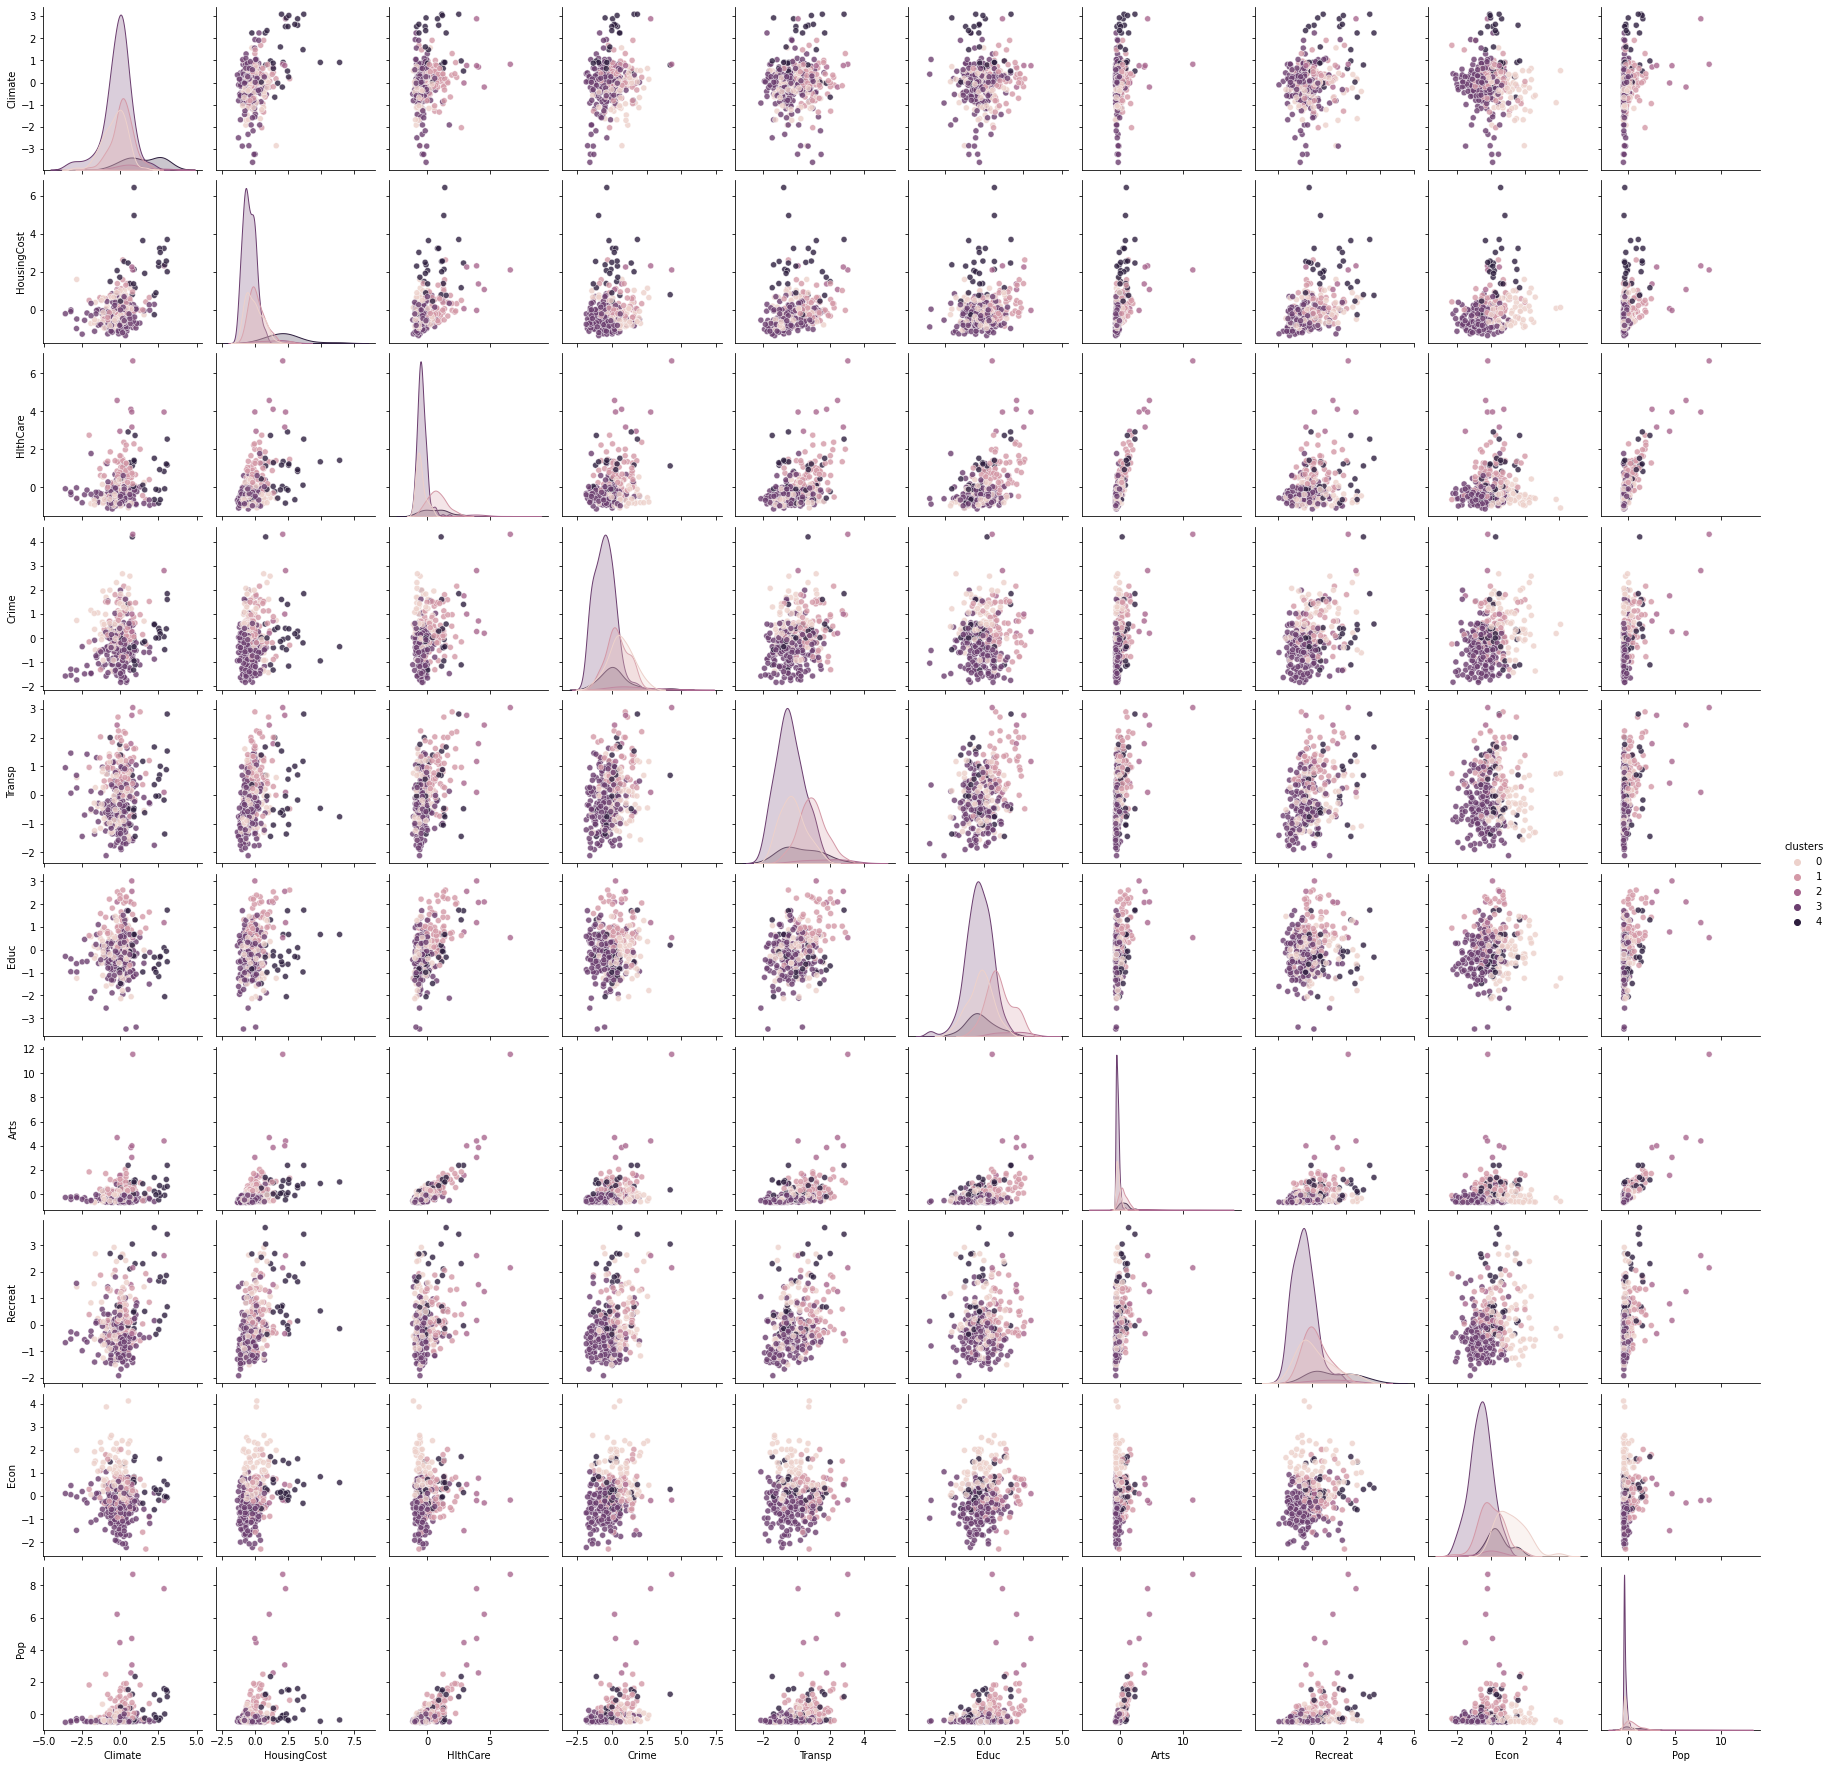

In [109]:
optimal_kmeans = KMeans(n_clusters=5).fit(kmeans_df)
kmeans_df['clusters'] = optimal_kmeans.labels_
sns.pairplot(kmeans_df, hue='clusters', plot_kws={'alpha': 0.8})
plt.show()

## Вывод
1) Подходящее количество кластеров для нашего датасета - 5, так как на этом месте наибольшой изгиб

2) Pairplot показал, что имеются 2 среднего размера кластера и 3 больших

# Задание 5 
## OPTICS

In [116]:
from sklearn.cluster import OPTICS

In [117]:
optics_df = df.copy()
optics_opt_clustering = OPTICS(min_samples=4).fit(optics_df)
optics_df['clusters'] = optics_opt_clustering.labels_
print('Clusters:', len(set(optics_opt_clustering.labels_)))

Clusters: 5


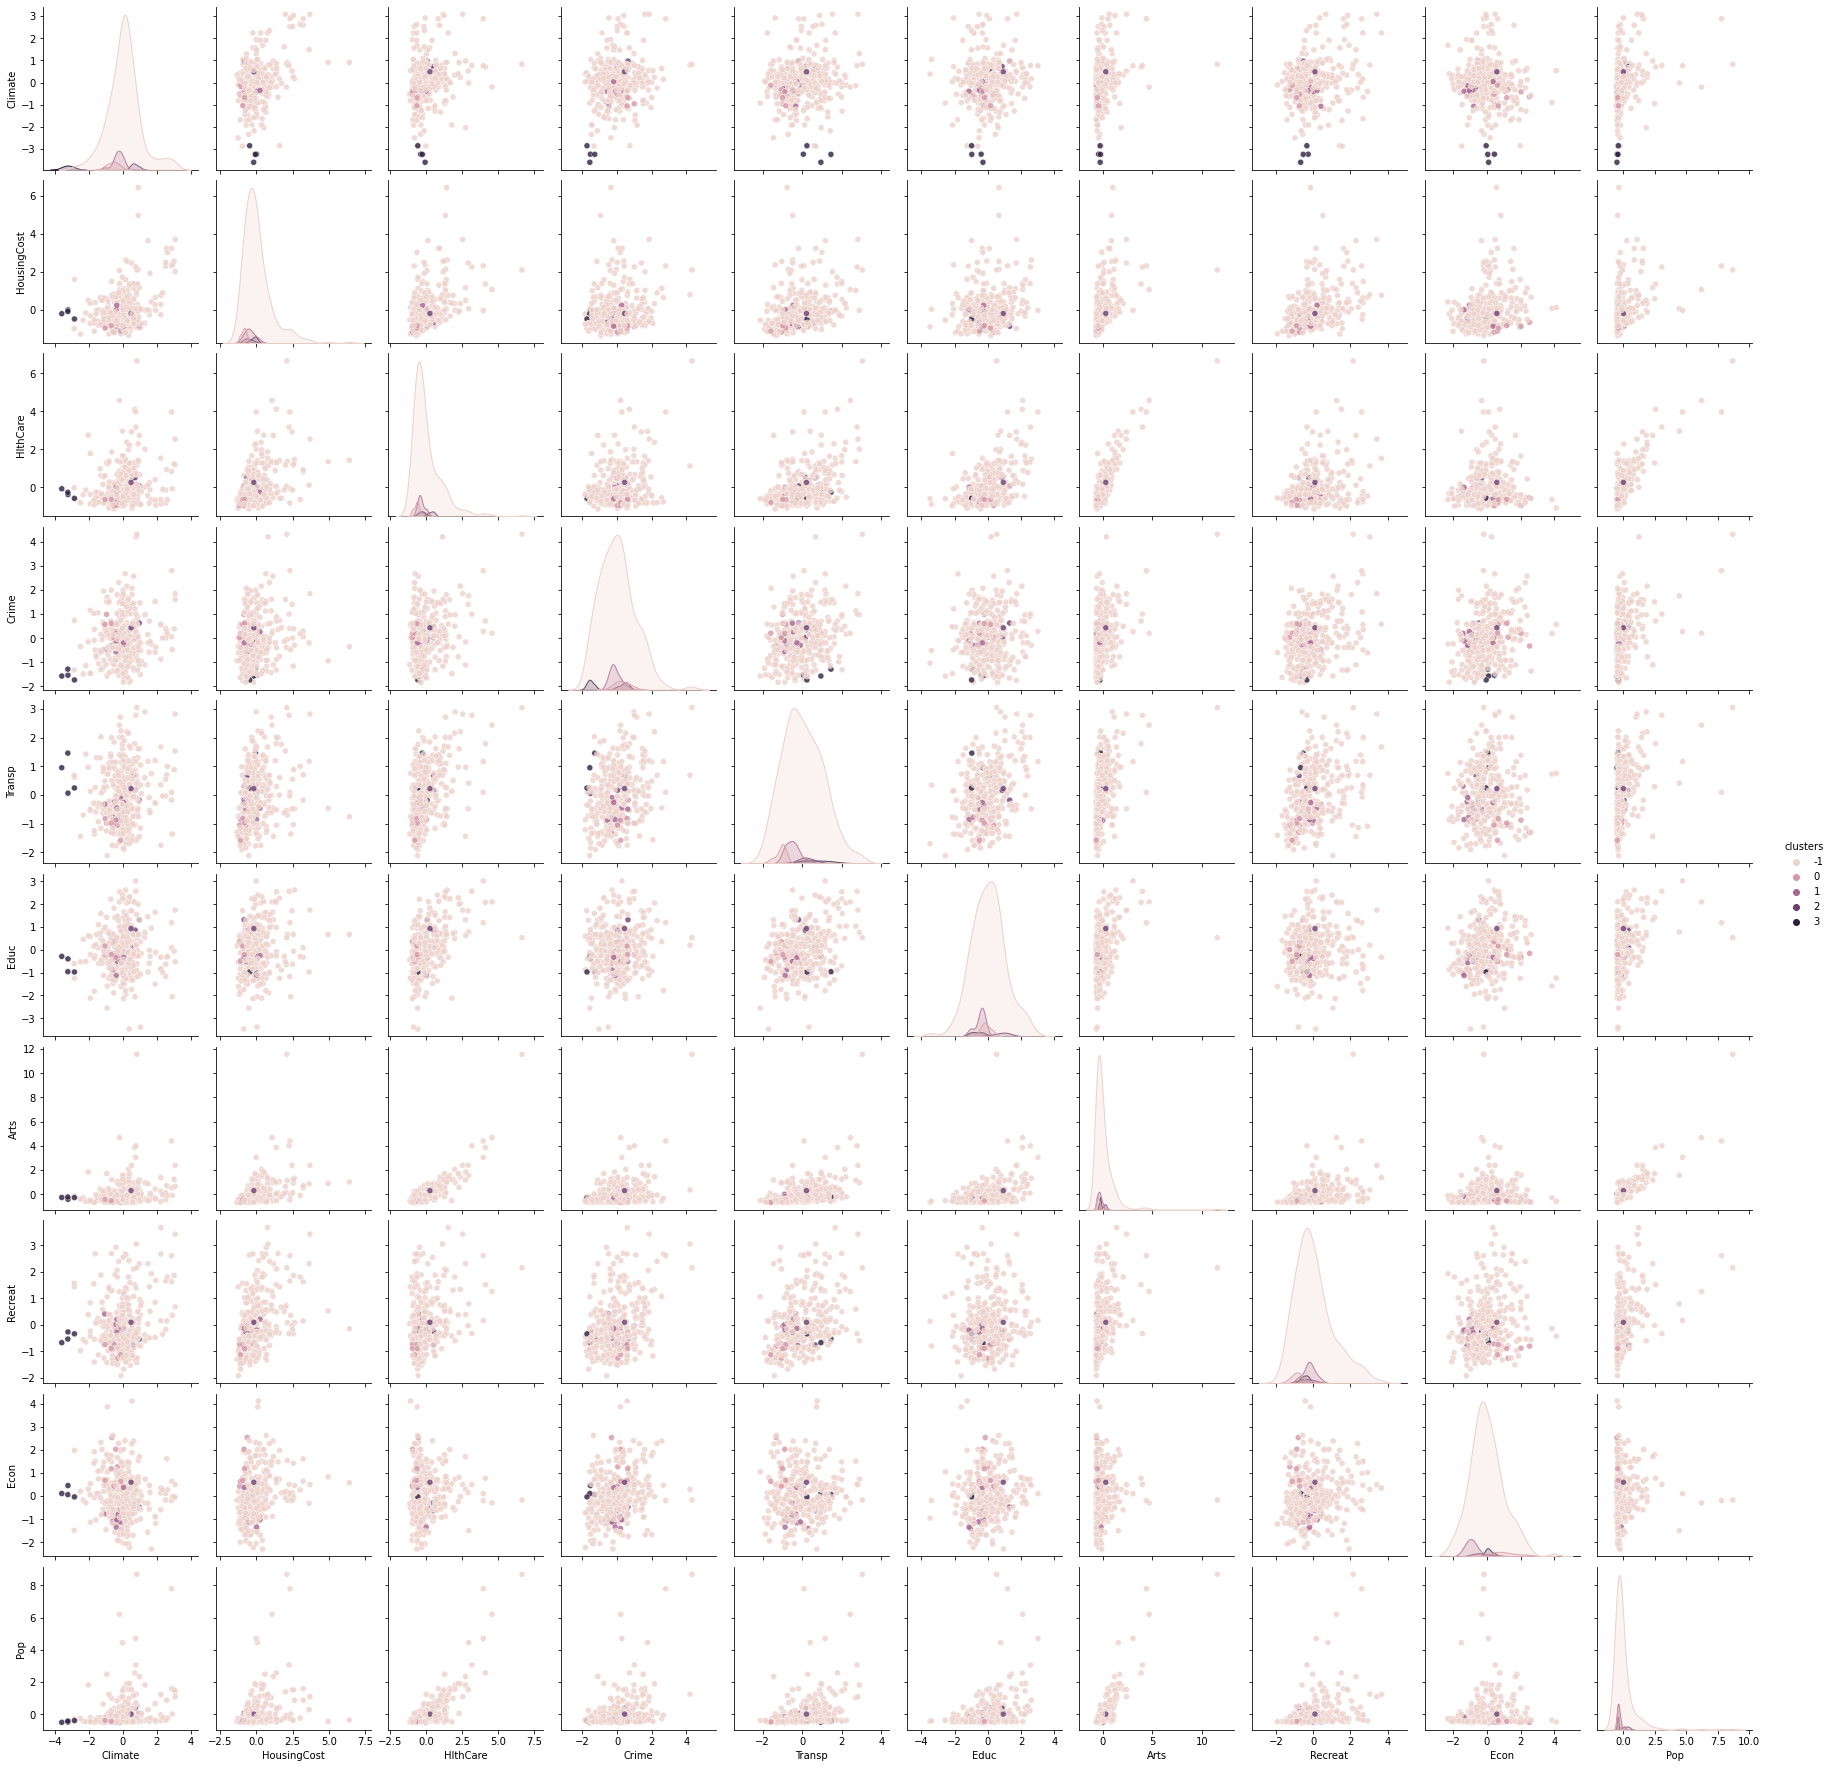

In [118]:
sns.pairplot(optics_df, hue='clusters', plot_kws={'alpha': 0.8})
plt.show()

## Вывод:

1) OPTICS выделила 5 кластеров, такой же результат показал K-Means

2) 4 маленьких кластера и 1 огромный

3) Нельзя сделать однозначного вывода по кластеризации

# Задание 6

In [119]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [120]:
print("Hierarchical - Method: Ward || Metric: Euclidean: ", silhouette_score(df, ward_eucl_block_labels))
print("K-Means (5 clusters): ", silhouette_score(df, optimal_kmeans.labels_))
print("DBSCAN: ", silhouette_score(df, dbs_min_eps.labels_))
print("OPTICS: ", silhouette_score(df, optics_opt_clustering.labels_))

Hierarchical - Method: Ward || Metric: Euclidean:  0.1480606777313674
K-Means (5 clusters):  0.18715462805026925
DBSCAN:  0.2490804203303003
OPTICS:  -0.2652162144724478


In [121]:

print("Hierarchical - Method: Ward || Metric: Euclidean: ", davies_bouldin_score(df, ward_eucl_block_labels))
print("K-Means (5 clusters): ", davies_bouldin_score(df, optimal_kmeans.labels_))
print("DBSCAN: ", davies_bouldin_score(df, dbs_min_eps.labels_))
print("OPTICS: ", davies_bouldin_score(df, optics_opt_clustering.labels_))

Hierarchical - Method: Ward || Metric: Euclidean:  1.8468990909824892
K-Means (5 clusters):  1.589028789283097
DBSCAN:  1.3604913057611097
OPTICS:  2.1136426363368317


In [122]:
from sklearn.metrics import calinski_harabasz_score
print("Hierarchical - Method: Ward || Metric: Euclidean: ", calinski_harabasz_score(df, ward_eucl_block_labels))
print("K-Means (5 clusters): ", calinski_harabasz_score(df, optimal_kmeans.labels_))
print("DBSCAN: ", calinski_harabasz_score(df, dbs_min_eps.labels_))
print("OPTICS: ", calinski_harabasz_score(df, optics_opt_clustering.labels_))

Hierarchical - Method: Ward || Metric: Euclidean:  65.94357287664604
K-Means (5 clusters):  68.66968829423779
DBSCAN:  19.81429242205717
OPTICS:  3.6386782834957536


## Вывод

1) Для оценки использовали метрики silhouette_score, davies_bouldin_score, calinski_harabasz_score

2) Hierarchical - Method: Ward || Metric: Euclidean в среднем показал неплохой результат, однако в Davies Bouldin значение далеко от 0

3) K-Means исходя из оценок показал самый лучшие результаты, скорее всего мы его возьмем за основной, также Calinski Harabasz близок к 100, что конечно хорошо

4) DBSCAN в некоторых случаях показал хороший результат, однако в Calinski Harabasz полностью провалился. Также silhouette_score показал, что метрика из всех близка к 1, что значит результат хороший, хотя не сказать, что идеальный

5) OPTICS при всех метриках показал наихудший результат, особенно в silhouette_score и calinski_harabasz_score, так как метрика близка к -1 в первом случае и очень далека от 100 во втором случае

### Самое лучшее разбиение - K-Means

# Задание 7

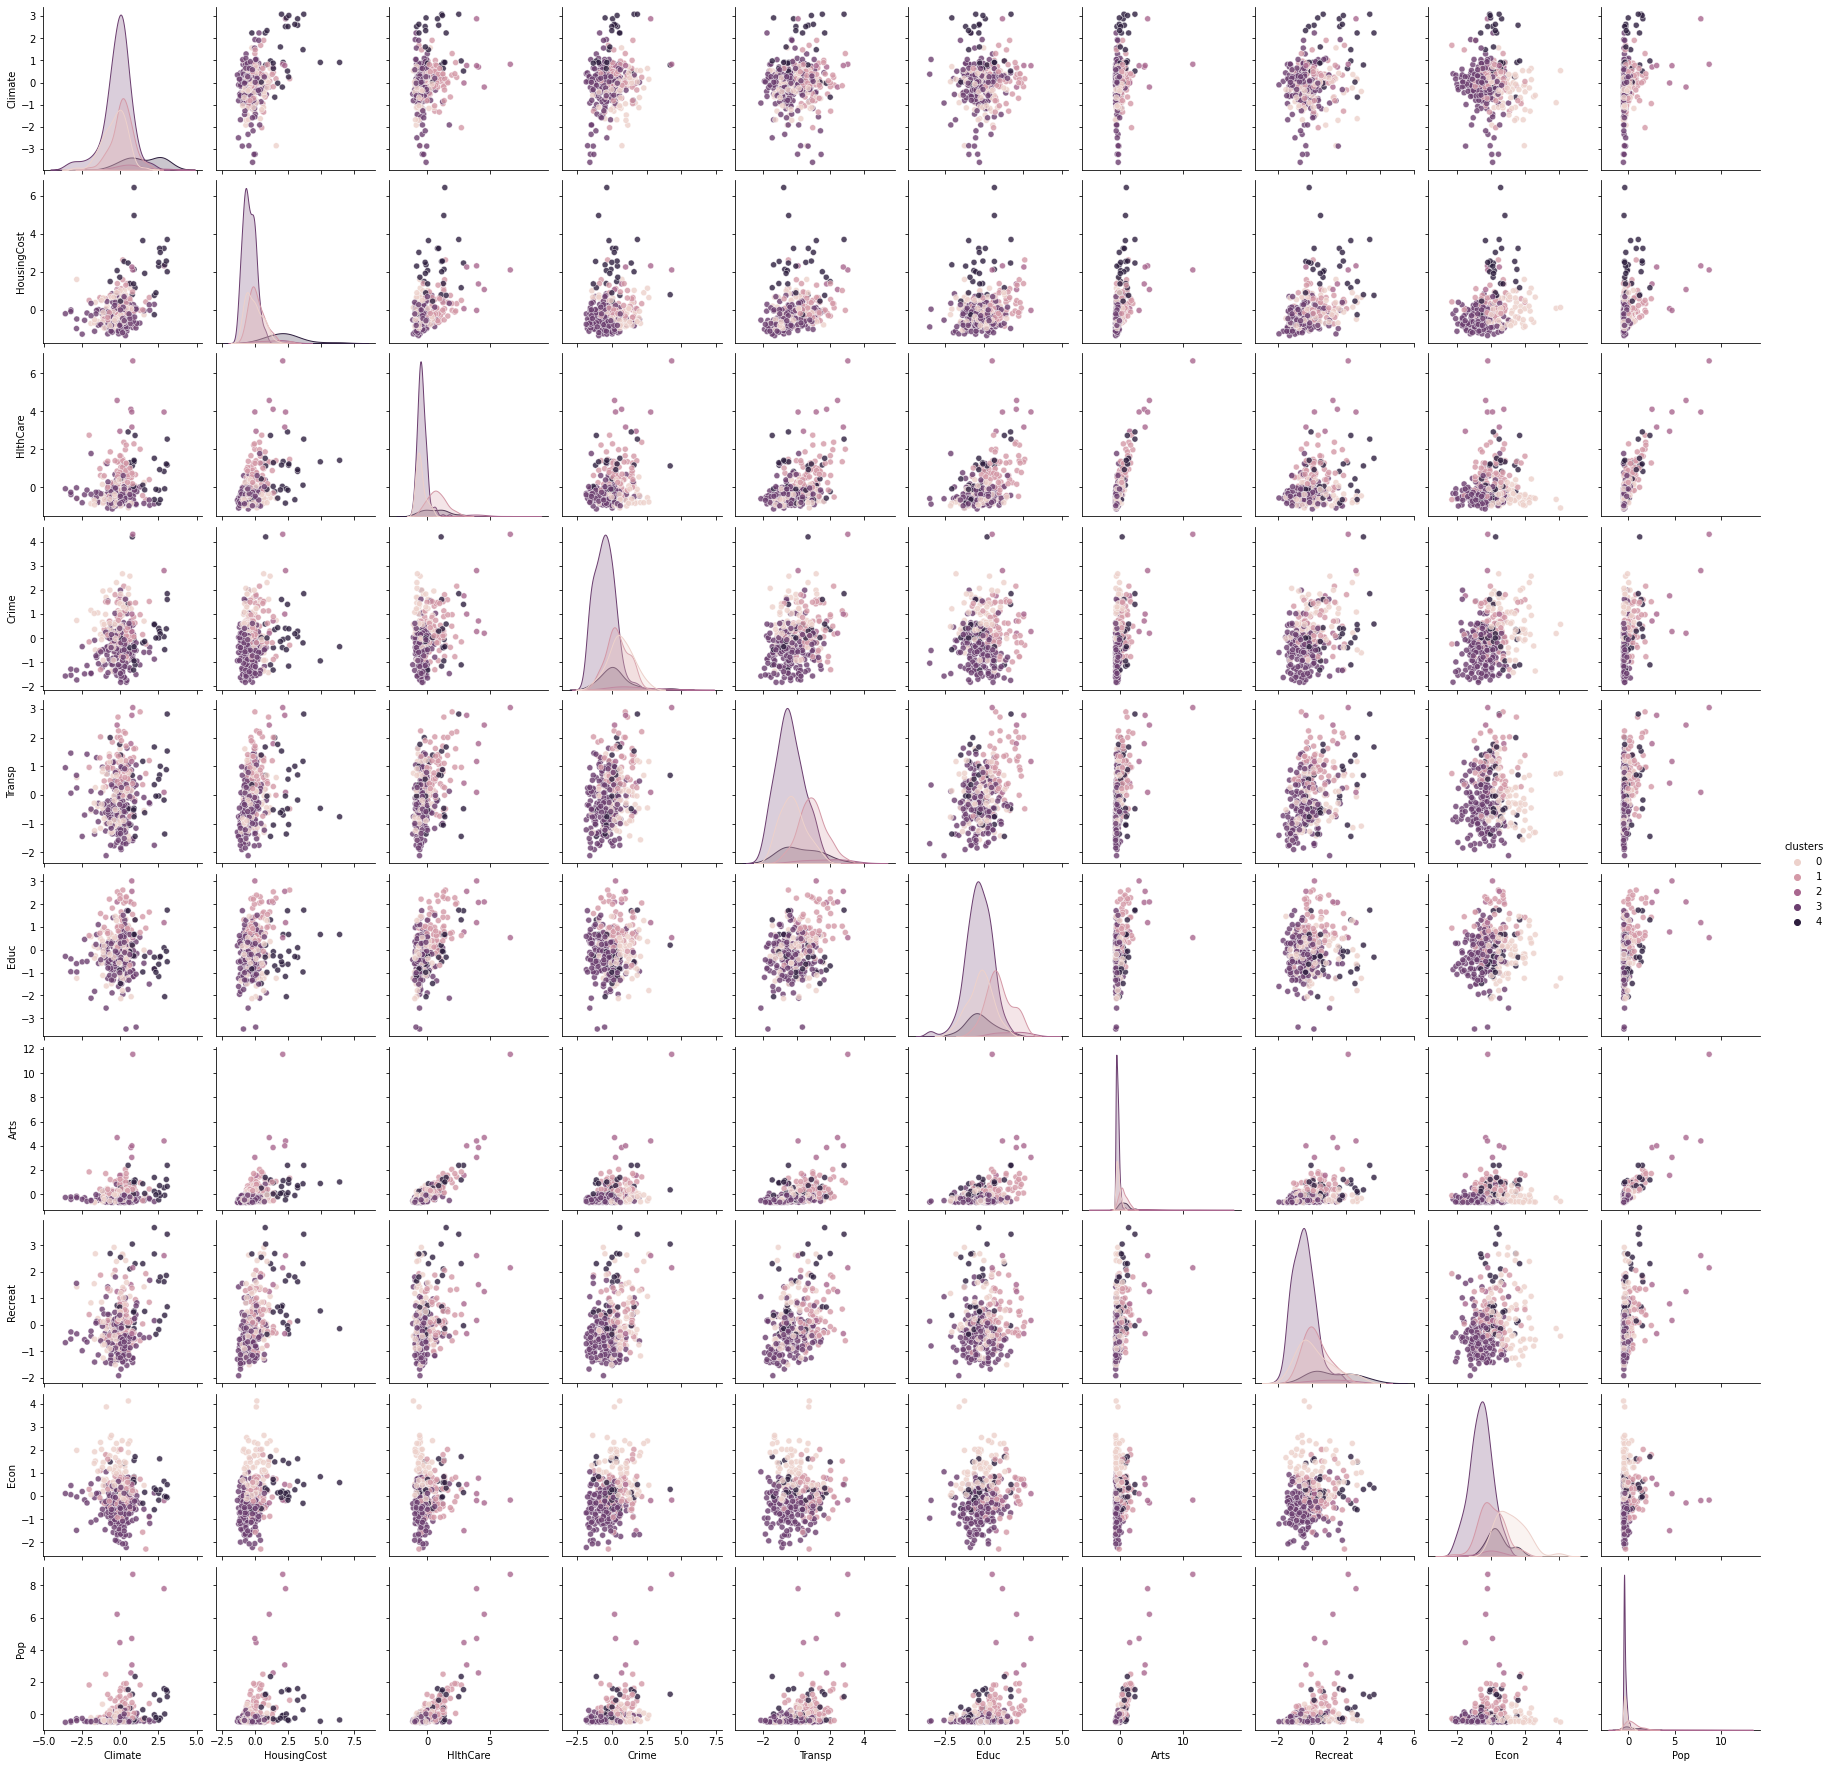

In [123]:
sns.pairplot(kmeans_df, hue='clusters', plot_kws={'alpha': 0.8})
plt.show()

### Разделим по данным наши кластеры и рассмотрим каждый из них

In [124]:
current_df = pd.read_csv('Data.txt', sep=' ')

In [125]:
current_df['clusters'] = optimal_kmeans.labels_

In [126]:
current_df.head()

Place  Climate  HousingCost  HlthCare  Crime  Transp  \
0                  Abilene,TX      521         6200       237    923    4031   
1                    Akron,OH      575         8138      1656    886    4883   
2                   Albany,GA      468         7339       618    970    2531   
3  Albany-Schenectady-Troy,NY      476         7908      1431    610    6883   
4              Albuquerque,NM      659         8393      1853   1483    6558   

   Educ  Arts  Recreat  Econ      Long      Lat     Pop  clusters  
0  2757   996     1405  7633  -99.6890  32.5590  110932         0  
1  2438  5564     2632  4350  -81.5180  41.0850  660328         3  
2  2560   237      859  5250  -84.1580  31.5750  112402         3  
3  3399  4655     1617  5864  -73.7983  42.7327  835880         1  
4  3026  4496     2612  5727 -106.6500  35.0830  419700         1

### Кластер 0

In [128]:
current_df[current_df.clusters == 0]

Place  Climate  HousingCost  \
0                                    Abilene,TX      521         6200   
9                                   Amarillo,TX      609         6546   
11                                 Anchorage,AK      195        12175   
20                             Atlantic-City,NJ      615        11074   
23                                    Austin,TX      435         8831   
..                                          ...      ...          ...   
312                                     Waco,TX      412         6106   
317  West-Palm-Beach-Boca-Raton-Delray-Beach,FL      509        10512   
319                                  Wichita,KS      494         7061   
320                            Wichita-Falls,TX      456         6404   
323                               Wilmington,NC      564         6858   

     HlthCare  Crime  Transp  Educ  Arts  Recreat  Econ      Long       Lat  \
0         237    923    4031  2757   996     1405  7633  -99.6890  32.55900   
9         669   1073    4902  2852  1235     1109  6241 -101.8490  35.38300   
11        601   1223    5091  2414  2346     3000  7668 -127.2016  48.88046   
20        637   1878    3556  2929   621     2711  8107  -74.4380  39.36700   
23        782   1049    3670  3063  5355     1063  7439  -97.7420  30.28200   
..        ...    ...     ...   ...   ...      ...   ...       ...       ...   
312       538   1166    3018  2867  1141     1248  6259  -97.1420  31.54700   
317       375   1783    5201  3224  2888     3772  7992  -80.2177  26.65530   
319       806   1164    3933  2981  2987     1508  6036  -97.3370  37.69200   
320       549   1179    2793  2747   599     1126  6805  -98.5130  33.91000   
323      1099   1423    2904  2876  1077     2668  5390  -77.9230  34.23700   

        Pop  clusters  
0    110932         0  
9    173699         0  
11   174431         0  
20   276385         0  
23   536688         0  
..      ...       ...  
312  170755         0  
317  576863         0  
319  411313         0  
320  121082         0  
323  103471         0  

[67 rows x 14 columns]

### Вывод по кластеру 0:
1) Хорошая экономика для мест

2) Маленькое население

3) Плохая медицина

### Кластер 1

In [129]:
current_df[current_df.clusters == 1]

Place  Climate  HousingCost  HlthCare  \
3            Albany-Schenectady-Troy,NY      476         7908      1431   
4                        Albuquerque,NM      659         8393      1853   
14                         Ann-Arbor,MI      546        11014      2508   
19                           Atlanta,GA      696         8316      3195   
25                         Baltimore,MD      567         9148      3562   
..                                  ...      ...          ...       ...   
293                         Syracuse,NY      548         7670      1040   
296  Tampa-St.-Petersburg-Clearwater,FL      440         7442      1189   
299                           Toledo,OH      518         7767      1738   
301                          Trenton,NJ      636        10616      1372   
322                 Wilmington,DE-NJ-MD      597         7927      1445   

     Crime  Transp  Educ  Arts  Recreat  Econ      Long      Lat      Pop  \
3      610    6883  3399  4655     1617  5864  -73.7983  42.7327   835880   
4     1483    6558  3026  4496     2612  5727 -106.6500  35.0830   419700   
14    1067    3433  3346  7559     2288  4579  -83.7500  42.2830   264748   
19    1308    8409  3057  7559     1362  6315  -84.3190  33.7630  2138231   
25    1730    7405  3471  9788     2925  5503  -76.6170  39.2880  2199531   
..     ...     ...   ...   ...      ...   ...       ...      ...      ...   
293    689    6951  3144  5080     2851  4474  -76.1500  43.0520   642971   
296   1493    5588  3044  5040     2943  7256  -82.6640  27.9550  1613603   
299    998    5323  2852  4389     1952  4534  -83.5280  41.5910   616864   
301   1181    4786  3311  5029     1646  5772  -74.7670  40.2250   307863   
322   1115    4532  3112  4545     1923  6174  -75.5500  39.7470   523221   

     clusters  
3           1  
4           1  
14          1  
19          1  
25          1  
..        ...  
293         1  
296         1  
299         1  
301         1  
322         1  

[66 rows x 14 columns]

### Вывод по кластеру
1) Высокое значение Transp, HealthCare и Arts 

2) Высокая/ Cредняя стоимость жилого помещения

3) Также высокая популяция

Скореее всего это большие города, но не слишком. По типу Нижнего Новгорода

### Кластер 2

In [135]:
current_df[current_df.clusters == 2]

Place  Climate  HousingCost  HlthCare  Crime  Transp  \
42                   Boston,MA      623        11609      5301   1215    6801   
64                  Chicago,IL      514        10913      5766   1034    7742   
85                  Detroit,MI      536         8525      4142   1587    4808   
178  Los-Angeles,Long-Beach,CA      885        13868      5153   1960    4345   
212                New-York,NY      638        13358      7850   2498    8625   
233         Philadelphia,PA-NJ      630         8310      5158   1059    5903   
313        Washington,DC-MD-VA      631        13724      4361   1317    8236   

     Educ   Arts  Recreat  Econ     Long      Lat      Pop  clusters  
42   3479  21042     3066  6363  -71.058  42.3620  2805911         2  
64   3486  24846     2856  5205  -87.625  41.8830  6060387         2  
85   3064  10389     2483  3904  -83.128  42.4420  4488072         2  
178  3195  23567     3948  5316 -118.217  33.9165  7477503         2  
212  2984  56745     3579  5338  -73.880  40.8490  8274961         2  
233  3781  17270     1979  5638  -75.163  39.9500  4716818         2  
313  3635  21701     1578  6072  -77.033  38.8920  3250822         2

### Вывод по кластеру
1) Высокая стоимость жилого помещения

2) Самый маленький кластер из всех имеющихся

3) Высокий уровень бандитизма

4) Хороший уровень арт объектов

Судя по всему, это одни из самых больших мегаполисов США

### Кластер 3

In [136]:
current_df[current_df.clusters == 3]

Place  Climate  HousingCost  HlthCare  Crime  Transp  \
1                     Akron,OH      575         8138      1656    886    4883   
2                    Albany,GA      468         7339       618    970    2531   
5                Alexandria,LA      520         5819       640    727    2444   
6    Allentown,Bethlehem,PA-NJ      559         8288       621    514    2881   
7        Alton,Granite-City,IL      537         6487       965    706    4975   
..                         ...      ...          ...       ...    ...     ...   
324               Worcester,MA      562         8715      1805    680    3643   
325                  Yakima,WA      535         6440       317   1106    3731   
326                    York,PA      540         8371       713    440    2267   
327       Youngstown-Warren,OH      570         7021      1097    938    3374   
328               Yuba-City,CA      608         7875       212   1179    2768   

     Educ  Arts  Recreat  Econ      Long      Lat     Pop  clusters  
1    2438  5564     2632  4350  -81.5180  41.0850  660328         3  
2    2560   237      859  5250  -84.1580  31.5750  112402         3  
5    2972   334     1018  5254  -92.4530  31.3020  135282         3  
6    3144  2333     1117  5097  -75.4405  40.6155  635481         3  
7    2945  1487     1280  5795  -90.1615  38.7940  268229         3  
..    ...   ...      ...   ...       ...      ...     ...       ...  
324  3299  1784      910  5040  -71.7950  42.2720  402918         3  
325  2491   996     2140  4986 -120.5130  46.5950  172508         3  
326  2903  1022      842  4946  -76.7280  39.9600  381255         3  
327  2920  2797     1327  3894  -80.7290  41.1700  531350         3  
328  2387   122      918  4694 -121.6220  39.1280  101979         3  

[162 rows x 14 columns]

### Вывод по кластеру 
1) В среднем низкий уровень здравоохранения 

2) Низкий уровень бандитизма

3) Низкий уровень экономики

Скорее всего, это маленькие городки

### Кластер 4

In [137]:
current_df[current_df.clusters == 4]

Place  Climate  HousingCost  HlthCare  \
10                  Anaheim-Santa-Ana,CA      885        16047      2025   
43                   Boulder-Longmont,CO      459        11914       962   
47                 Bridgeport-Milford,CT      648        13429      2550   
77                            Danbury,CT      569        14420      2350   
132                          Honolulu,HI      717        17021      1298   
161                       Lake-County,IL      514        13282      1237   
191                     Miami-Hialeah,FL      634        10267      2314   
199                    Monmouth-Ocean,NJ      615        11660      2482   
206                    Nassua-Suffolk,NY      656        11138      3919   
213                            Newark,NJ      601        14220      4106   
216                           Norwalk,CT      648        20151      2530   
217                           Oakland,CA      910        13135      2362   
226                    Oxnard-Ventura,CA      890        14000      1106   
249                              Reno,NV      535        12449       615   
263                    Salem-Glouster,MA      644        11622      1232   
264          Salinas-Seaside-Monterey,CA      843        13838       352   
265              Salt-Lake-City-Ogden,UT      541         9466      1631   
268                         San-Diego,CA      903        14465      2416   
269                     San-Francisco,CA      910        17158      3726   
270                          San-Jose,CA      850        16048      2117   
271  Santa-Barbara-Santa-Maria-Lompoc,CA      855        15547       532   
272                        Santa-Cruz,CA      843        14303      1035   
273               Santa-Rosa-Petaluma,CA      732        12931      1052   
277                           Seattle,WA      808        10183      2715   
289                          Stamford,CT      648        23640      2610   
294                            Tacoma,WA      808         7770       539   
307            Vallejo-Fairfield-Napa,CA      821        10503      1079   

     Crime  Transp  Educ   Arts  Recreat  Econ      Long      Lat      Pop  \
10     983    3954  2843   5632     3156  6220 -117.8890  33.7990  1932709   
43    1088    7108  2587   3663     4012  7127 -105.1930  40.0915   189625   
47     943    3197  3029   8368     1913  7197  -73.1265  41.2075   438557   
77     548    2715  3029   7415     1572  7060  -73.4600  41.3930   170369   
132    891    5911  2502   7168     3703  5187 -126.0568  31.7365   762565   
161    822    3422  2607   3746     2435  5755  -88.6180  39.6360   440372   
191   2459    5202  2879   4837     4300  5840  -80.2185  25.6465  1625781   
199    819    2690  2787   7563     3544  6154  -74.0750  40.3520   849211   
206    566    2119  3234   8640     3705  7371  -73.3750  40.6780  2605813   
213   1461    3514  3362  14224     1818  5690  -74.1720  40.7370  1878959   
216    625    3536  3029   7273     2268  6432  -73.3650  41.1230   126692   
217   1533    6430  2646   6162     2394  5457 -122.2680  37.8080  1761759   
226    791    2238  2155   2769     2135  5514 -119.2030  34.2375   529174   
249   1116    6767  2529   2210     2386  5677 -119.8070  39.5230   193623   
263    490    3459  2729   3276     2234  6309  -70.7815  42.5755   258175   
264   1107    4160  2439   1004     3179  5656 -121.8010  36.6343   290444   
265    969    6228  2340   5528     3900  4942 -111.9350  40.8825   910222   
268   1099    5489  2794   8818     3347  5489 -117.1530  32.7130  1861846   
269   1619    8299  3371  14226     4600  6063 -122.4170  37.7750  1488871   
270   1065    5224  2709   6446     1964  7270 -121.8830  37.3350  1295071   
271   1026    5662  2719   2684     3300  5821 -120.1960  34.6707   298694   
272    964    5010  2611   3748     1703  5335 -122.0220  36.9720   188141   
273    912    3313  2722   3457     2255  5703 -122.6790  38.3375   299681   
277   1170    6634  2710   9577   

### Вывод по кластеру 
1) Высокая стоимость жилого помещения

2) Среднее высокое значение по транспорту и искусству

3) Невысокий уровень криминала

Наверное, это города близкие к мегаполисам

# Задание 8

In [140]:
import folium

In [142]:
colors = {0: "red",
          1: "green",
          2: "orange",
          3: "blue",
          4: "black"}
_map = folium.Map(location=[39.091431, -96.655998], zoom_start=4)
for index, example in current_df.iterrows():
    folium.Marker(location=(example.Lat, example["Long"])
                  , icon=folium.Icon(color=colors[example["clusters"]]),
                  ).add_to(_map)
_map

## Вывод

1) Как мы видим, действительно, оранжевые - это крупнейшие мегаполисы США (Washington, Detroit ...)

2) Голубые это не большие городки, которые находятся в основном в центре и рядом с крупными городами

3) Что интересно, города красного класстера в основном сосредоточены с правой части карты и их большое количество в Техасе и Майами. Возможно, есть какая-то географическая зависимость

4) К кластерам черного цвета относятся города, которые находятся вплотную к большим мегаполисам или сами являются каким-либо городским центром. Наши ожидания из 7го задания подтвердились

5) Опять же зеленым отмечены в основном средние городки, хотя не такие маленькие как синие, зеленые намного крупнее, например Аталанта, Мемфис и т.д.

На самом деле кластеризация разделила наши данные более или менее правдоподно и логично.